In [1]:
library(scDesign3)
library(scales)
library(dplyr)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
example_sce <- readRDS((url("https://figshare.com/ndownloader/files/40582019")))
print(example_sce)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQR

class: SingleCellExperiment 
dim: 1000 2696 
metadata(0):
assays(2): counts logcounts
rownames(1000): Calb2 Gng4 ... Fndc5 Gda
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [3]:
mt_idx<- grep("mt-",rownames(example_sce))
if(length(mt_idx)!=0){
    example_sce <- example_sce[-mt_idx,]
}

In [4]:
set.seed(1)
example_data <- construct_data(
    sce = example_sce,
    assay_use = "counts",
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
  )

In [5]:
example_marginal <- fit_marginal(
    data = example_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k=50)",
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 5,
    usebam = FALSE
  )

# try bs='tp', s(, by='cell_type')

In [6]:
set.seed(1)
example_copula <- fit_copula(
    sce = example_sce,
    assay_use = "counts",
    marginal_list = example_marginal,
    family_use = "nb",
    copula = "gaussian",
    n_cores = 2,
    input_data = example_data$dat
  )

Convert Residuals to Multivariate Gaussian

Converting End

Copula group 1 starts



In [7]:
example_para <- extract_para(
    sce = example_sce,
    marginal_list = example_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = example_data$newCovariate,
    data = example_data$dat
  )

In [8]:
dev_explain <- sapply(example_marginal, function(x){
  sum = summary(x$fit)
  return(sum$dev.expl)
})
dev_ordered <- order(dev_explain, decreasing = TRUE)

In [9]:
df_dev_explain <- as.data.frame(dev_explain)
df_dev_explain$gene <- rownames(df_dev_explain)

df_dev_explain$ranking <- rank(-df_dev_explain$dev_explain)

write.csv(df_dev_explain, './scDesign3_v2/dev_explain.csv')

In [10]:
head(df_dev_explain)

,dev_explain,gene,ranking
,<dbl>,<chr>,<dbl>
Calb2,0.7584198,Calb2,13
Gng4,0.7467810,Gng4,16
Ttr,0.9011457,Ttr,1
S100a5,0.8998154,S100a5,2
Nrgn,0.6868249,Nrgn,48
Doc2g,0.7304346,Doc2g,20


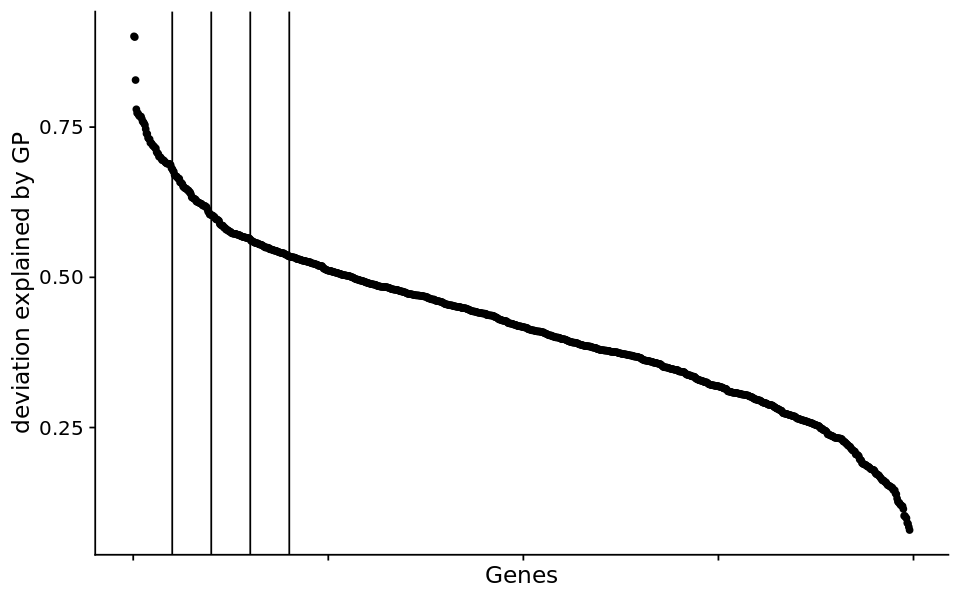

In [11]:
options(repr.plot.width = 8, repr.plot.height = 5)

p <- ggplot(data = df_dev_explain, aes(x = ranking, y = dev_explain)) +
    geom_point() +
    geom_vline(xintercept = 50) +
    geom_vline(xintercept = 100) +
    geom_vline(xintercept = 150) +
    geom_vline(xintercept = 200) +
    theme_cowplot() +
    xlab("Genes") + ylab("deviation explained by GP") +
    theme(axis.text.x = element_blank())

p

In [12]:
head(df_dev_explain)

,dev_explain,gene,ranking
,<dbl>,<chr>,<dbl>
Calb2,0.7584198,Calb2,13
Gng4,0.7467810,Gng4,16
Ttr,0.9011457,Ttr,1
S100a5,0.8998154,S100a5,2
Nrgn,0.6868249,Nrgn,48
Doc2g,0.7304346,Doc2g,20


In [13]:
num_de = 100

ordered <- dev_explain[dev_ordered]
de_idx <- names(ordered)[1:num_de]
non_de_idx <- names(ordered)[-(1:num_de)]
non_de_mat <- apply(example_para$mean_mat[, non_de_idx], 2, function(x){
    avg <- (max(x)+min(x))/2
    new_mean <- rep(avg, length(x))
    return(new_mean)
})
example_para$mean_mat[, non_de_idx] <- non_de_mat

In [14]:
for(seed in c(1, 2, 3, 4, 5)){
        set.seed(seed)
        example_newcount <- simu_new(
            sce = example_sce,
            mean_mat = example_para$mean_mat,
            sigma_mat = example_para$sigma_mat,
            zero_mat = example_para$zero_mat,
            quantile_mat = NULL,
            copula_list = example_copula$copula_list,
            n_cores = 5,
            family_use = "nb",
            input_data = example_data$dat,
            new_covariate = example_data$newCovariate,
            important_feature = rep(TRUE, dim(example_sce)[1]),
            filtered_gene = NULL
          )

        simu_sce <- SingleCellExperiment(list(counts =example_newcount), 
                                         colData = example_data$newCovariate)
        loc = colData(simu_sce)[, c("spatial1","spatial2")]

        write.csv(loc, file = "./scDesign3_v2/location.csv")
        write.csv(example_newcount, file = glue::glue('./scDesign3_v2/counts_seed_{seed}.csv'))
        write.csv(de_idx, file = glue::glue('./scDesign3_v2/labels_seed_{seed}.csv'))
        write.csv(non_de_idx, file = glue::glue('./scDesign3_v2/labels_non_seed_{seed}.csv'))
}

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [15]:
# simu_sce <- SingleCellExperiment(list(counts =example_newcount), colData = example_data$newCovariate)
# logcounts(simu_sce) <- log1p(counts(simu_sce))

In [16]:
# de_genes = de_idx[1:5]
# loc = colData(simu_sce)[,c("spatial1","spatial2")]
# expre = lapply(de_genes, function(x){
#     curr = as.matrix(counts(simu_sce)[x,])
#     curr = log1p(curr)
#     return(rescale(curr))
#   })
# long = do.call(rbind, expre)
# long = as.data.frame(long)
# colnames(long) <- "Expression"
# long$gene = do.call(c, lapply(de_genes, function(x){rep(x,dim(expre[[1]])[1])}))
# long$x = rep(loc[,1],5)
# long$y = rep(loc[,2],5)
# as_tibble(long, rownames = "Cell") %>% ggplot(aes(x = x, y = y, color = Expression)) +
# geom_point(size = 0.1)+facet_grid(~gene)+ scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) + coord_fixed(ratio = 1) + theme(axis.text.x = element_text(angle = 45))